In [279]:
import numpy as np
import gstools as gs
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

# 生成数据
x = np.linspace(0, 25, 25)
y = np.linspace(0, 25, 25)
XX, YY = np.meshgrid(x, y)

# 第一个数据
model = gs.Gaussian(dim=2, var=1, len_scale=3)
srf = gs.SRF(model, mean=0.)
srf((x, y), mesh_type='structured')
B0 = srf((x, y), mesh_type='structured', seed=100)

# 将B0转换为适合聚类的格式
data = B0.reshape(-1, 1)

In [280]:
from sklearn_extra.cluster import KMedoids
def process_data_with_randomness(data):

# 进行K-means聚类分析
    # noisy_data = data + np.random.normal(0.3, 0.1, data.shape)+np.random.laplace(0,0.1,  data.shape)+np.random.poisson(0.02,data.shape)
    noisy_data = data +np.random.laplace(0.2,0.01, data.shape)+ np.random.poisson(0.2,data.shape)+np.random.normal(0.2, 0.01, data.shape)
    # noise=np.random.laplace(0,0.1,  y_pred_full.shape)+np.random.poisson(0.02,y_pred_full.shape)
    kmeans = KMeans(n_clusters=4).fit(noisy_data)
    labels = kmeans.labels_

    # 将标签重新转换为B0的形状
    clustered_B0 = labels.reshape(B0.shape)

    return labels

# def process_data_with_randomness(data):

#     noisy_data = data + np.random.laplace(0.02,0.01, data.shape)+ np.random.poisson(0.01,data.shape)+np.random.normal(0.01, 0.01, data.shape)
#     # 进行K-medoids聚类分析
#     kmedoids = KMedoids(n_clusters=4, random_state=None).fit(noisy_data)
#     labels = kmedoids.labels_

#     # 将标签重新转换为B0的形状
#     clustered_B0 = labels.reshape(B0.shape)

#     return labels


# 收集所有的 processed_values
all_processed_values = []
indexForCalu=101
# 运行过程 1000 次并存储结果
for i in range(1, indexForCalu):
    print(i)
    processed_values = process_data_with_randomness(data)
    all_processed_values.append(pd.Series(processed_values, name=f'Out{i}'))

# Initialize the dataframe to store results
results_df = pd.DataFrame()
# 将所有列一次性连接到 results_df 中
results_df = pd.concat(all_processed_values, axis=1)
results_df["value"] =B0.ravel()
results_df.to_csv("repro-out-test/pred_noisy_1000.csv", index=False)
# 检查结果
print(results_df)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
     Out1  Out2  Out3  Out4  Out5  Out6  Out7  Out8  Out9  Out10  ...  Out92  \
0       3     3     0     0     1     0     3     0     2      1  ...      0   
1       3     0     0     0     1     0     3     0     0      1  ...      1   
2       3     0     1     0     2     3     1     3     3      2  ...      1   
3       1     0     0     0     2     0     1     3     3      2  ...      1   
4       3     0     2     0     1     0     3     2     2      1  ...      0   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...    ...  ...    ...   
620     1     2     1     3     1     0     3     3     3      2  ...      0   
621     3     0     0     0     1     0     0     0     2      1  ..

In [281]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from itertools import combinations
import warnings 
warnings.filterwarnings("ignore")

# 生成示例数据
df = pd.read_csv("repro-out-test/pred_noisy_1000.csv")

out0 = df["Out0"]=df["cluster"]=pd.read_csv("pred_nonoisy_initial.csv")
x= df.index
data = df.copy()

In [282]:
# 定义属性模板
attributes_template = ["value"]
results_df = pd.DataFrame()
# 计算特定聚类的质心的函数
def calculate_centroids_with_attrs(data, clustering_col, attributes):
    centroids = {}
    for cluster_id in range(4):
        cluster_data = data[data[clustering_col] == cluster_id]
        centroid = cluster_data[attributes].mean()
        centroids[cluster_id] = centroid
    return centroids

def calculate_row(data, cluster_col, attributes, row_name, df):
    centroids = calculate_centroids_with_attrs(data, cluster_col, attributes)
    
    # 提取质心值并构建一个数据框
    centroids_df = pd.DataFrame(centroids).T
    centroids_df.columns = ['value']
    
    # 按照Rooftop_area进行排序
    centroids_df = centroids_df.sort_values(by='value')

    # 重新分配新的聚类标签
    sorted_clusters = centroids_df.index.tolist()

    cluster_mapping = {original_cluster: new_cluster for new_cluster, original_cluster in enumerate(sorted_clusters, start=1)}

    data[f'new_{cluster_col}'] = data[cluster_col].map(cluster_mapping)
    
    # 重新计算新的聚类质心
    new_centroids = calculate_centroids_with_attrs(data, f'new_{cluster_col}', attributes)
    new_centroids_df = pd.DataFrame(new_centroids).T
    new_centroids_df.columns = ['value']
    
    # 检查空值
    # print(f"new_{cluster_col} column null values:", data[f'new_{cluster_col}'].isnull().sum())
    # print(f"new_centroids_df null values:", new_centroids_df['value'].isnull().sum())
    
    # 将排序后的结果添加到结果数据框中
    df[row_name] = list(new_centroids_df['value'])

    return data, df

# 计算每个复现聚类结果的质心
for i in range(indexForCalu):
    # print(i)
    cluster_col = f'Out{i}'
    attributes = attributes_template
    data_repro, results_df = calculate_row(data, cluster_col, attributes, f'Out{i}', results_df)

# data.to_csv('repro-out/filtered_data.csv')
print(data_repro)
data_repro.to_csv('repro-out-test/filtered_data.csv')

     Out1  Out2  Out3  Out4  Out5  Out6  Out7  Out8  Out9  Out10  ...  \
0       3     3     0     0     1     0     3     0     2      1  ...   
1       3     0     0     0     1     0     3     0     0      1  ...   
2       3     0     1     0     2     3     1     3     3      2  ...   
3       1     0     0     0     2     0     1     3     3      2  ...   
4       3     0     2     0     1     0     3     2     2      1  ...   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...    ...  ...   
620     1     2     1     3     1     0     3     3     3      2  ...   
621     3     0     0     0     1     0     0     0     2      1  ...   
622     0     3     2     1     3     2     0     2     2      3  ...   
623     0     1     2     1     3     2     0     2     2      3  ...   
624     0     3     2     1     3     2     0     2     2      3  ...   

     new_Out91  new_Out92  new_Out93  new_Out94  new_Out95  new_Out96  \
0            3          3          3          4   

In [283]:
# 筛选data_repro中包含新列的部分
filtered_data_repro = data[[f'new_Out{i}' for i in range(1, indexForCalu)]]

# 计算每一行的cluster数及出现的频率
cluster_counts = filtered_data_repro.apply(pd.Series.value_counts, axis=1).fillna(0)
cluster_frequencies = cluster_counts.div(cluster_counts.sum(axis=1), axis=0)

# new_pred_cols = [f'new_pred{i}' for i in range(1, 1001)]
# filtered_data_repro['clusters_array'] = filtered_data_repro[new_pred_cols].apply(lambda row: row.unique(), axis=1)


filtered_data_repro.to_csv('repro-out-test/filtered_data_repro.csv')
# print(filtered_data_repro)

filtered_data_initial = data[[f'new_Out0']]
print(filtered_data_initial)

     new_Out0
0           3
1           3
2           3
3           3
4           3
..        ...
620         2
621         3
622         4
623         4
624         4

[625 rows x 1 columns]


In [284]:
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('repro-out-test/filtered_data.csv')

relative_frequency=[]

# 创建频率分布图的函数
def plot_histogram(row_data, row_index):
    initial_value=filtered_data_initial.loc[row_index,:].values[0]
    unique, counts = np.unique(row_data, return_counts=True)
    frequencies = dict(zip(unique, counts))
    # print(frequencies)
    
    categories = [1, 2, 3, 4]
    frequency_values = [frequencies.get(category, 0) for category in categories]
    # print(frequency_values)
    # 确定initial_value所在的类别及其频率
    initial_category = int(initial_value)
    initial_frequency = frequencies.get(initial_category, 0)
    relative_frequency.append(initial_frequency / len(row_data)) 
    # print(relative_frequency)

    # plt.figure(figsize=(10, 6))
    # plt.bar(categories, frequency_values, tick_label=categories,alpha=0.3,label="Reproduced values")
    # plt.title(f'Frequency Distribution of Row {row_index} \n The probability of reproducbility is {initial_frequency / len(row_data) *100}%')
    # plt.axvline(x=initial_category, color='red', linestyle='dashed', linewidth=2, label=f'Initial value: {initial_value}')
    # plt.legend()
    # plt.xlabel('Category')
    # plt.ylabel('Frequency')
    # plt.ylim(0, max(frequency_values) + 10)  # Adjust ylim for better visualization
    # plt.show()

# 为每一行绘制直方图 filtered_data_repro.shape[0]
# print(filtered_data_repro.loc[0,:])
data2 = pd.read_csv('repro-out-test/filtered_data_repro.csv')
# filtered_data_repro= data2.iloc[:,1:1001]
# print(filtered_data_repro)
for i in range(1,filtered_data_repro.shape[0]):
    plot_histogram(filtered_data_repro.loc[i,:], i)

# 计算initial_relative_frequency数组的期望（均值）
expected_value = np.mean(relative_frequency)
print("Expected Value of Initial Relative Frequencies:", expected_value)


Expected Value of Initial Relative Frequencies: 0.7197756410256411


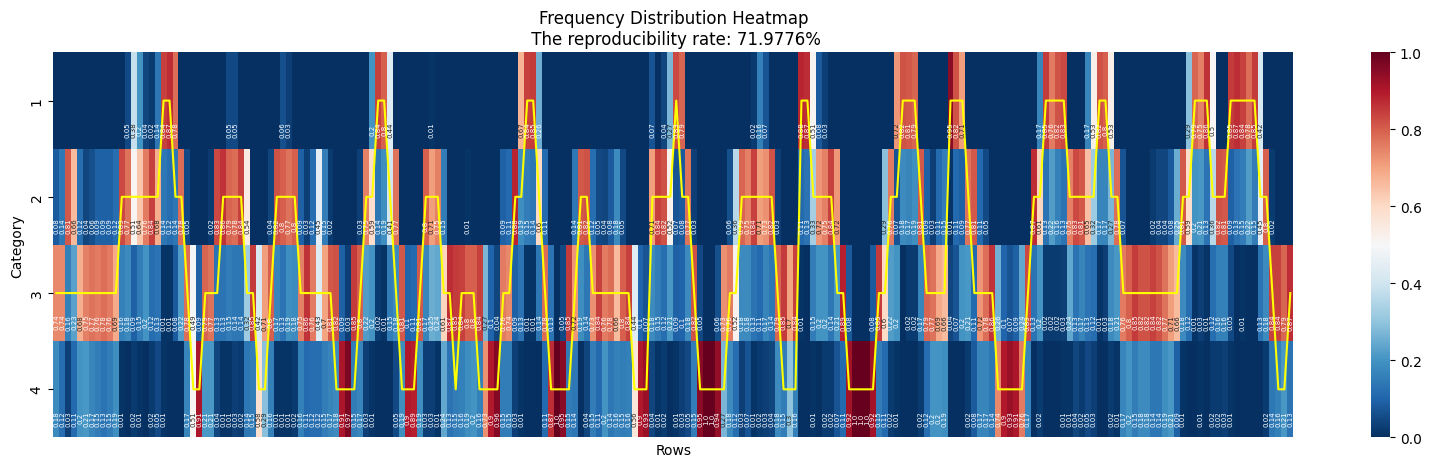

In [300]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# 仅选择前20行的数据
number = filtered_data_repro.shape[0]//3
repro = filtered_data_repro.iloc[:number, :]
initial = filtered_data_initial.iloc[:number, :]
# repro = filtered_data_repro
# initial = filtered_data_initial

# 创建一个矩阵来存储频率分布
frequency_matrix = np.zeros((repro.shape[0], 4))

# 填充频率矩阵
for i in range(repro.shape[0]):
    row_data = repro.loc[i, :]
    unique, counts = np.unique(row_data, return_counts=True)
    frequencies = dict(zip(unique, counts))
    for category in [1, 2, 3, 4]:
        frequency_matrix[i, category - 1] = frequencies.get(category, 0) / len(row_data)

# 创建一个矩阵来存储注释（只显示值大于0的标签）
annotations = np.where(frequency_matrix > 0, np.round(frequency_matrix, 2), '')

# 绘制热力图
plt.figure(figsize=(20, 5))

ax = sns.heatmap(frequency_matrix.T, annot=annotations.T, fmt="", xticklabels=False, yticklabels=[1, 2, 3, 4], cmap="RdBu_r", cbar=True,
                 annot_kws={"size": 5, "ha": "center", "va": "center", "rotation": 90,"clip_on": True}) #cmap="viridis"

plt.title(f'Frequency Distribution Heatmap\n The reproducibility rate: {round(expected_value*100,4)}%')
plt.ylabel('Category')
plt.xlabel('Rows')

# 调整标签的位置
for text in ax.texts:
    text.set_y(float(text.get_position()[1]) + 0.3)

# 添加表示filtered_data_initial的线
initial_values = initial['new_Out0'].values - 1  # 将值转换为索引
plt.plot(np.arange(0.5, repro.shape[0] + 0.5), initial_values + 0.5, color='yellow', linewidth=1.5, label='Initial Value')
plt.savefig("repro-out/heatmap.svg")
plt.show()


计算 ARI 统计量:
原始结果与复现结果之间的ARI 95%置信区间: (0.2336648082008882, 0.5821606589815482);随机误差范围: (0.16856309120957275, 0.42273359463828597)
ARI置信区间覆盖率: 0.54252808；概率0.8196


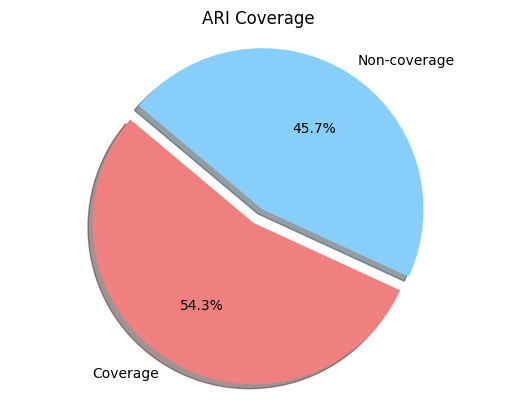


计算 NMI 统计量:
原始结果与复现结果之间的NMI 95%置信区间: (0.33975391645437425, 0.5902439159627705);随机误差范围: (0.22615734128313472, 0.42985714984389023)
NMI置信区间覆盖率: 0.35970791；概率0.6144


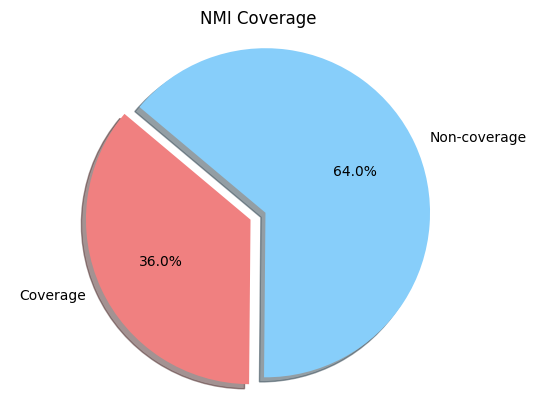


计算 Kappa 统计量:
原始结果与复现结果之间的Kappa 95%置信区间: (0.3002308745444708, 0.7492794482938135);随机误差范围: (0.2719045708724043, 0.6397579880903549)
Kappa置信区间覆盖率: 0.75610331；概率0.9508


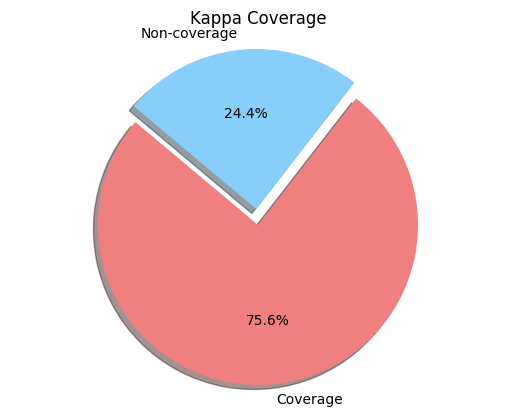

In [288]:
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, cohen_kappa_score
from itertools import combinations
import scipy.stats as stats

# 设定随机种子以确保结果一致


# 计算置信区间
def calculate_confidence_interval(values, alpha=0.05):
    values = np.sort(values)
    lower_bound = np.percentile(values, alpha / 2 * 100)
    upper_bound = np.percentile(values, (1 - alpha / 2) * 100)
    return lower_bound, upper_bound

# 蒙特卡洛抽样并计算指定类型的统计量
def monteCarloMethod(num_samples, data, stat_type):
    monteCarlo_statistics_values = []
    sampled_combinations = [np.random.choice(data.columns, 2, replace=False) for _ in range(num_samples)]
    
    for comb in sampled_combinations:
        i, j = comb
        monteCarlo_statistics_values.append(calculate_statistic_values(data[i], data[j], stat_type))
    
    return monteCarlo_statistics_values



# 计算指定类型的统计量
def calculate_statistic_values(data1, data2, stat_type):
    if stat_type == "ARI":
        return adjusted_rand_score(data1, data2)
    elif stat_type == "NMI":
        return normalized_mutual_info_score(data1, data2)
    elif stat_type == "Kappa":
        return cohen_kappa_score(data1, data2)

# 计算覆盖率
def calculate_coverage(interval1, interval2):
    L1, U1 = interval1
    L2, U2 = interval2
    L_overlap = max(L1, L2)
    U_overlap = min(U1, U2)
    if L_overlap > U_overlap:
        return 0.0
    overlap_length = U_overlap - L_overlap
    length1 = U1 - L1
    coverage = overlap_length / length1
    return coverage
# def calculate_proportion(values, lower_bound, upper_bound):
#     # value
#     return np.sum((values >= lower_bound) & (values <= upper_bound)) / len(values)
def calculate_proportion(values, lower_bound, upper_bound):
    # 确保 values 是一个一维数组或列表
    values = np.asarray(values).flatten()
    
    common_count = 0
    total_count = len(values)
    for value in values:
        if lower_bound <= value <= upper_bound:
            common_count += 1
            
    return common_count / total_count

# 数据加载
data_df = pd.read_csv('repro-out-test/filtered_data.csv')
filtered_data_repro = data_df[[f'new_Out{i}' for i in range(1, indexForCalu)]]
out0 = data_df['new_Out0']

# 定义要计算的统计量类型
stat_types = ["ARI", "NMI", "Kappa"]  # 可选值："ARI", "NMI", "Kappa"

for stat_type in stat_types:
    print(f"\n计算 {stat_type} 统计量:") 
    # 计算原始结果与复现结果的指定统计量
    real_values = [calculate_statistic_values(out0, filtered_data_repro[f'new_Out{i}'], stat_type) for i in range(1, indexForCalu)]
    # 计算置信区间-----总误差
    ci_low, ci_high = calculate_confidence_interval(real_values)
    # -----随机误差
    monteCarlo_values = monteCarloMethod(10000, filtered_data_repro, stat_type)
    ci_low_mc_random, ci_high_mc_random = calculate_confidence_interval(monteCarlo_values)
    print(f"原始结果与复现结果之间的{stat_type} 95%置信区间: ({ci_low}, {ci_high});随机误差范围: ({ci_low_mc_random}, {ci_high_mc_random})")
    # 计算覆盖率

    ratio_original = calculate_proportion(monteCarlo_values, ci_low, 1)


    coverage = calculate_coverage((ci_low, ci_high), (ci_low_mc_random, ci_high_mc_random))
    print(f"{stat_type}置信区间覆盖率: {coverage:.8f}；概率{ratio_original}")
    # 绘制覆盖率图

     # 绘制覆盖率的饼图
    fig, ax = plt.subplots()
    labels = ['Coverage', 'Non-coverage']
    sizes = [coverage, 1-coverage]
    colors = ['lightcoral', 'lightskyblue']
    explode = (0.1, 0)  # 突出显示覆盖率
    ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
           shadow=True, startangle=140)
    ax.axis('equal')
    plt.title(f'{stat_type} Coverage')
    plt.show()


In [287]:
from sklearn.metrics import (
    adjusted_rand_score, 
    adjusted_mutual_info_score, 
    homogeneity_completeness_v_measure, 
    fowlkes_mallows_score, 
    jaccard_score
)

def calculate_clustering_similarity(true_labels, predicted_labels):
    similarity_measures = {
        "Adjusted Rand Index": adjusted_rand_score,
        "Adjusted Mutual Information": adjusted_mutual_info_score,
        "Homogeneity": lambda x, y: homogeneity_completeness_v_measure(x, y)[0],
        "Completeness": lambda x, y: homogeneity_completeness_v_measure(x, y)[1],
        "V-Measure": lambda x, y: homogeneity_completeness_v_measure(x, y)[2],
        "Fowlkes-Mallows Index": fowlkes_mallows_score,
        "Jaccard Index": lambda x, y: jaccard_score(
            [1 if label == 0 else 0 for label in x], 
            [1 if label == 0 else 0 for label in y]
        )  # Example for binary case, adjust accordingly for multi-class
    }
    
    results = {}
    for measure_name, measure_func in similarity_measures.items():
        results[measure_name] = measure_func(true_labels, predicted_labels)
    
    return results

# 示例聚类标签
labels_true = data["Out0"]
labels_pred = data["Out18"]

# 计算相似性
similarity_results = calculate_clustering_similarity(labels_true, labels_pred)

# 打印结果
for measure, result in similarity_results.items():
    print(f"{measure}: {result}")

Adjusted Rand Index: 0.45686634037173524
Adjusted Mutual Information: 0.4790553937179992
Homogeneity: 0.48129481070094343
Completeness: 0.4825785079623778
V-Measure: 0.4819358045104787
Fowlkes-Mallows Index: 0.6114090179524049
Jaccard Index: 0.04941860465116279


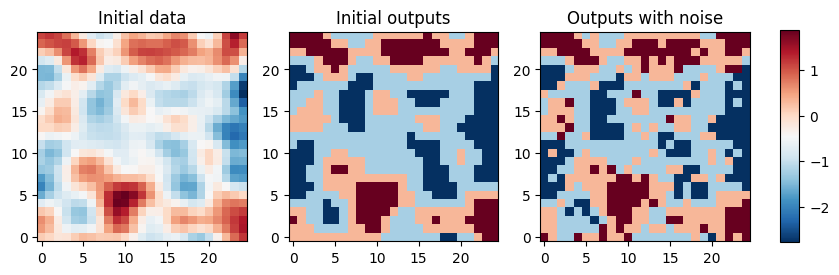

In [299]:
out0 = pd.read_csv("pred_nonoisy_initial.csv")
outs = pd.read_csv("repro-out-test/filtered_data.csv")
clustered_Out0 = outs["new_Out0"].values.reshape(B0.shape)
clustered_Out1 = outs["new_Out9"].values.reshape(B0.shape)

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 原始随机场
im0 = axes[0].imshow(B0, origin='lower', cmap='RdBu_r')
axes[0].set_title('Initial data')

im1 = axes[1].imshow(clustered_Out0, origin='lower', cmap='RdBu_r')
axes[1].set_title('Initial outputs')

im2 = axes[2].imshow(clustered_Out1, origin='lower', cmap='RdBu_r')
axes[2].set_title('Outputs with noise')

# 调整子图间距，避免颜色条与图片重叠
fig.subplots_adjust(right=0.6)

# 创建一个公共颜色条
cbar_ax = fig.add_axes([0.62, 0.23, 0.013, 0.53])  # [左, 下, 宽, 高]
cbar = fig.colorbar(im0, cax=cbar_ax, orientation='vertical')

plt.show()